## Predictor variable selection ## 

#### forward selection (Eforymson 1966; Draper and Smith 1966) ####

Iteratively build up a model by adding one predictor variable at a time, starting one with no predictors.

Run the following 3 steps until you run out of predictors:
1. For each unused predictor, add it to the model to form a candidate model.
2. Tune all of the candidate models.
3. Update the model to be the candidate model with the highest cross-validation accuracy.

Select the model that provides the best trade-off between accuracy and simplicity.

### set-up ###

In [175]:
# loading packages
library(repr)
library(tidyverse)
library(tidymodels)
# library(themis)

In [176]:
# loading data
stroke <- read_csv("data/stroke-data.csv")
colnames(stroke)
seed <- 31

Parsed with column specification:
cols(
  id = col_double(),
  gender = col_character(),
  age = col_double(),
  hypertension = col_double(),
  heart_disease = col_double(),
  ever_married = col_character(),
  work_type = col_character(),
  Residence_type = col_character(),
  avg_glucose_level = col_double(),
  bmi = col_character(),
  smoking_status = col_character(),
  stroke = col_double()
)



[1] "id"                "gender"            "age"              
 [4] "hypertension"      "heart_disease"     "ever_married"     
 [7] "work_type"         "Residence_type"    "avg_glucose_level"
[10] "bmi"               "smoking_status"    "stroke"

In [177]:
# prep and bake data with upsampling, then use it with everything
# gonna overfit data, data leakage
stroke_clean <- stroke %>%
    select(age, hypertension, heart_disease, avg_glucose_level, bmi, stroke) %>%
    mutate(stroke = as_factor(stroke),
           bmi = as.numeric(bmi)) 

Warning message:
“Problem with `mutate()` input `bmi`.
ℹ NAs introduced by coercion
ℹ Input `bmi` is `as.numeric(bmi)`.”
Warning message in mask$eval_all_mutate(dots[[i]]):
“NAs introduced by coercion”


#### Split data

In [178]:
set.seed(seed)
stroke_split <- initial_split(stroke_clean, prop = 0.75, strata = stroke)
stroke_train <- training(stroke_split)
stroke_test <- testing(stroke_split)


set.seed(seed)
standardize_recipe <- recipe(stroke ~ ., data = stroke_test) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors()) %>%
    prep()

stroke_test_standardized <- bake(standardize_recipe, stroke_test)

### Downsampling

In [179]:
set.seed(seed)
ds_recipe <- recipe(stroke ~ ., data = stroke_train) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors()) %>%
    step_downsample(stroke, under_ratio = 1, skip = FALSE) %>%
    prep()
dsampled_stroke <- bake(ds_recipe, stroke_train)

dsampled_stroke %>%
    group_by(stroke) %>%
    summarize(n = n())

`summarise()` ungrouping output (override with `.groups` argument)



stroke,n
<fct>,<int>
0,189
1,189


### Forward Selection

In [180]:
# DOWNSAMPLE here!!!

In [181]:
stroke_subset <- dsampled_stroke %>%
    filter(!is.na(bmi))
names <- colnames(dsampled_stroke %>% select(-stroke))
names

[1] "age"               "hypertension"      "heart_disease"    
[4] "avg_glucose_level" "bmi"

In [182]:
example_formula <- paste("stroke", "~", paste(names, collapse="+"))
example_formula

[1] "stroke ~ age+hypertension+heart_disease+avg_glucose_level+bmi"

In [183]:
# create an empty tibble to store the results
accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())
accuracies

size,model_string,accuracy
<int>,<chr>,<dbl>


In [184]:
# create a model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) %>%
     set_engine("kknn") %>%
     set_mode("classification")

# create a 5-fold cross-validation object
stroke_vfold <- vfold_cv(stroke_subset, v = 5, strata = stroke)

# This value was chosen for gridvals to increase the accuracy of the forward selection, while making it so that the forward selection did not take
# too long to run
gridvals <- tibble(neighbors = seq(from = 1, to = 20, by = 5))

In [185]:
# store the total number of predictors
n_total <- length(names)

# stores selected predictors
selected <- c()

In [186]:
set.seed(seed)
# Note: takes about 30s to run
# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    print("start")
    # for every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, names[[j]])
        model_string <- paste("stroke", "~", paste(preds_new, collapse="+"))
        print(model_string)
        
        # create a recipe from the model string
        stroke_recipe <- recipe(as.formula(model_string), 
                                data = stroke_subset) %>%
                          step_scale(all_predictors()) %>%
                          step_center(all_predictors())

        # tune the KNN classifier with these predictors, 
        # and collect the accuracy for the best K
        set.seed(seed)
        acc <- workflow() %>%
          add_recipe(stroke_recipe) %>%
          add_model(knn_spec) %>%
          tune_grid(resamples = stroke_vfold, grid = gridvals) %>%
          collect_metrics() %>%
          filter(.metric == "accuracy") %>%
          summarize(mx = max(mean))
        acc <- acc$mx %>% unlist()

        # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    set.seed(seed)
    print("unlist")
    print(unlist(accs))
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies %>% 
      add_row(size = i, 
              model_string = models[[jstar]], 
              accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}
accuracies

[1] "start"
[1] "stroke ~ age"
[1] "stroke ~ hypertension"
[1] "stroke ~ heart_disease"
[1] "stroke ~ avg_glucose_level"
[1] "stroke ~ bmi"
[1] "unlist"
[1] 0.7179454 0.6280477 0.5872123 0.6512788 0.5319267
[1] "start"
[1] "stroke ~ age+hypertension"
[1] "stroke ~ age+heart_disease"
[1] "stroke ~ age+avg_glucose_level"
[1] "stroke ~ age+bmi"
[1] "unlist"
[1] 0.7470162 0.7410912 0.7528559 0.7414749
[1] "start"
[1] "stroke ~ age+avg_glucose_level+hypertension"
[1] "stroke ~ age+avg_glucose_level+heart_disease"
[1] "stroke ~ age+avg_glucose_level+bmi"
[1] "unlist"
[1] 0.7673913 0.7323956 0.7325661
[1] "start"
[1] "stroke ~ age+avg_glucose_level+hypertension+heart_disease"
[1] "stroke ~ age+avg_glucose_level+hypertension+bmi"
[1] "unlist"
[1] 0.7527280 0.7412191
[1] "start"
[1] "stroke ~ age+avg_glucose_level+hypertension+heart_disease+bmi"
[1] "unlist"
[1] 0.735422


size,model_string,accuracy
<int>,<chr>,<dbl>
1,stroke ~ age,0.7179454
2,stroke ~ age+avg_glucose_level,0.7528559
3,stroke ~ age+avg_glucose_level+hypertension,0.7673913
4,stroke ~ age+avg_glucose_level+hypertension+heart_disease,0.7527280
5,stroke ~ age+avg_glucose_level+hypertension+heart_disease+bmi,0.7354220


In [187]:
accuracies

size,model_string,accuracy
<int>,<chr>,<dbl>
1,stroke ~ age,0.7179454
2,stroke ~ age+avg_glucose_level,0.7528559
3,stroke ~ age+avg_glucose_level+hypertension,0.7673913
4,stroke ~ age+avg_glucose_level+hypertension+heart_disease,0.7527280
5,stroke ~ age+avg_glucose_level+hypertension+heart_disease+bmi,0.7354220


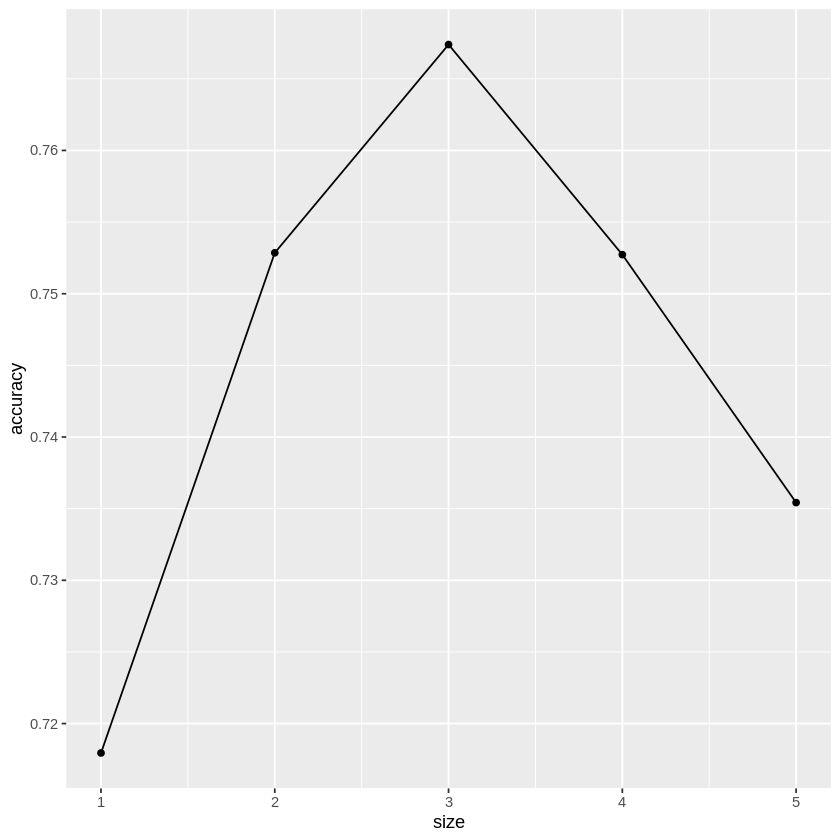

In [188]:
ggplot(accuracies, aes(x=size, y=accuracy)) +
geom_line() +
geom_point()

## with predict ##

In [189]:
set.seed(seed)
stroke_recipe <- recipe(stroke ~ avg_glucose_level + age, data = dsampled_stroke) %>%
  step_scale(all_predictors()) %>%
  step_center(all_predictors())

In [190]:
set.seed(seed)
stroke_vfold <- vfold_cv(dsampled_stroke, v = 5, strata = stroke)
# We chose to perform cross-validation with 1-75 neighbours. We chose the cap it at 75 and step it up by 3 to prevent the computational time from being 
# too long while still giving a fairly accurate estimate of the optimal k value.
k_vals <- tibble(neighbors = seq(from = 1, to = 75, by = 3))

In [191]:
set.seed(seed)
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
  set_engine("kknn") %>%
  set_mode("classification")

In [192]:
set.seed(seed)
knn_results <- workflow() %>%
  add_recipe(stroke_recipe) %>%
  add_model(knn_spec) %>%
  tune_grid(resamples = stroke_vfold, grid = k_vals) %>%
  collect_metrics() 

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
10,accuracy,binary,0.7751778,5,0.01844095,Model04


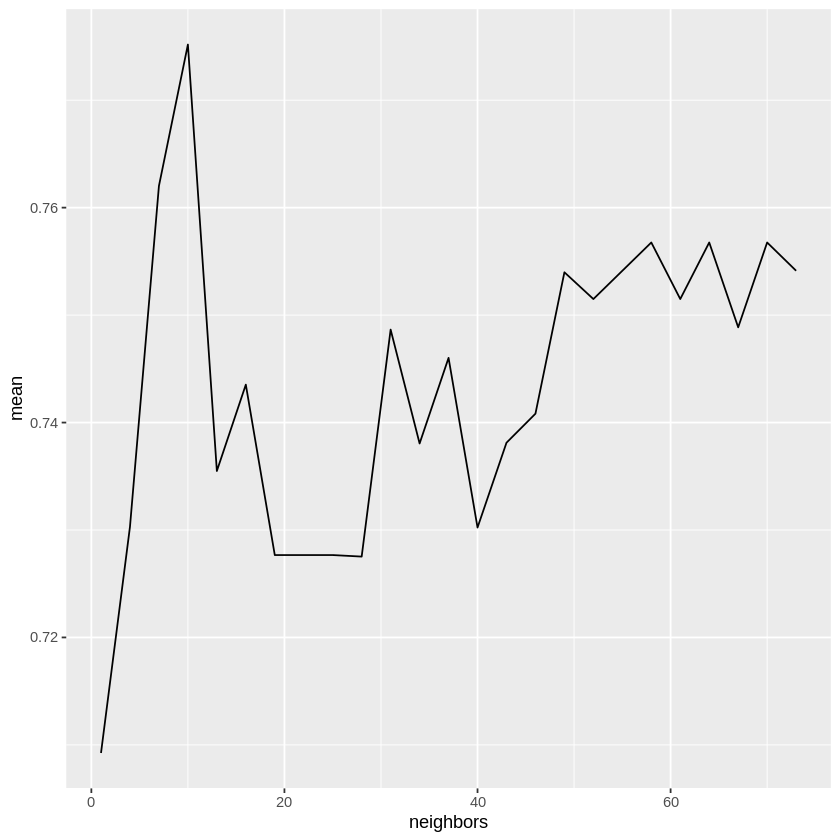

In [193]:
accuracies <- knn_results %>% # Plot accuracies vs neighbours
  filter(.metric == "accuracy")
ggplot(accuracies, aes(x=neighbors, y=mean)) +
    geom_line()
optimal_neighbours <- accuracies %>%
  filter(mean == max(mean))
optimal_neighbours

In [194]:
# We chose to select K=10, as it gives the highest estimated accuracy from our cross-validation. 
# Furthermore, K=10 is not too comupationally expensive, making it a suitable value to 
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 10) %>%
  set_engine("kknn") %>%
  set_mode("classification")

set.seed(seed)
# workflow + fit data
knn_fit <- workflow() %>%
  add_recipe(stroke_recipe) %>%
  add_model(knn_spec) %>%
  fit(data = dsampled_stroke)

stroke_test_predictions <- predict(knn_fit, stroke_test_standardized) %>%
  bind_cols(stroke_test_standardized) %>%
  metrics(truth = stroke, estimate = .pred_class)
stroke_test_predictions

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7055599
kap,binary,0.1429622
